# Visualize video processing

In [12]:
from ultralytics import YOLO
import os
import pandas as pd
import cv2
from cv2 import Mat
import sys
import matplotlib.pyplot as plt
HOME = os.getcwd()
print(f"Directory: {HOME}")
print(f"Python version: {sys.version}")

Directory: c:\Users\Thomas\Pictures\YOLOv3
Python version: 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]


Load a pre-trained model

In [3]:
train_folders = [folder for folder in os.listdir(os.path.join(HOME, 'runs\\detect')) if 'train' in folder]
most_recent_train = os.path.join(HOME, 'runs', 'detect',  train_folders[-1], 'weights', 'best.pt')
if os.path.exists(most_recent_train):
    model = YOLO(model=most_recent_train)
    print(model.info())
else:
    print("No pre-trained model found")

Model summary: 225 layers, 11136374 parameters, 0 gradients, 28.6 GFLOPs


(11136374, 28.6491136)


Function to make predictions, configure the confidence threshold and optionally visualize and/or save the result

In [4]:
def predict_image(model: YOLO, img: Mat | str, threshold: float = 0.5, save: bool = False, show: bool = False) -> Mat | None:
    if isinstance(img, str):
        img = cv2.imread(img)

    predictions = model.predict(img)
    results = predictions[0]
    bounding_boxes = results.boxes
    height, width, channels = img.shape
    img = cv2.resize(img, (width*2, height*2), interpolation=cv2.INTER_CUBIC)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
    workers = 0
    drones = 0
    for box in bounding_boxes:
        x1, y1, x2, y2, conf, classid = box.data.tolist()[0]
        x1 = int(x1)*2; y1 = int(y1)*2; x2 = int(x2)*2; y2 = int(y2)*2; conf = float(conf); classid = int(classid)
        if conf < threshold:
            continue
        label = f'{int(conf*100)}%'
        color = (0, 127, 200)
        if classid == 0:
            workers += 1
            color = (255, 34, 134)
        else:
            drones += 1
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        #fill rectangle with semi transparent color
        overlay = img.copy()
        cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 0, 0), -1)
        img = cv2.addWeighted(overlay, 0.2, img, 0.8, 0)
        
        cv2.rectangle(img, (x1, y1-40), (x1+60, y1), color, -1)
        cv2.putText(img, label, (x1, y1-12), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
    if save:
        cv2.imwrite("result.png", img)
    if show:
        # downscale image for display
        cv2.imshow("Result", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return (img, workers, drones)

Test some images to get general idea of model performance

In [5]:
test1 = os.path.join(HOME, "test_images", "1.jpg")
test2 = os.path.join(HOME, "test_images", "2.jpg")
test3 = os.path.join(HOME, "test_images", "3.jpg")
test4 = os.path.join(HOME, "test_images", "4.jpg")

In [8]:
predict_image(model=model, img=test1, threshold=0.5, save=True, show=True)  #This one is saved to the current directory
predict_image(model=model, img=test2, threshold=0.5, save=False, show=True)
predict_image(model=model, img=test3, threshold=0.5, save=False, show=True)
predict_image(model=model, img=test4, threshold=0.5, save=False, show=True)
print("")

0: 640x640 2 Drones, 4 Workers, 140.1ms
Speed: 9.0ms preprocess, 140.1ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Drones, 24 Workers, 141.2ms
Speed: 11.0ms preprocess, 141.2ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Drones, 15 Workers, 92.8ms
Speed: 8.0ms preprocess, 92.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Workers, 93.1ms
Speed: 9.0ms preprocess, 93.1ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)


Visualise a video of bees using YOLO model

In [9]:
def process_video_with_bounding_boxes(model: YOLO, video_path: str, output_path: str, detection_func, frames_interval: int = 10, threshold: float = 0.5):
    df = pd.DataFrame(columns=['workers', 'drones'])
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap_fps = int(cap.get(cv2.CAP_PROP_FPS))
    print("Original FPS: ", cap_fps)
    out_fps = int(cap_fps / frames_interval)
    print("Output FPS: ", out_fps)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, out_fps, (frame_width, frame_height))
    frame_count = 0
    modified_frame = None
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frames_interval == 0 or modified_frame is None:
            modified_frame, workers, drones = detection_func(model=model, img=frame, threshold=threshold, save=False, show=False)
            df.loc[len(df)] = [workers, drones]
            out.write(modified_frame)
        frame_count += 1
    cap.release()
    out.release()
    df.to_csv("result.csv", index=False)

In [10]:
video = "input_video.h264"
process_video_with_bounding_boxes(model=model, video_path=video, output_path="output_video.mp4", threshold=0.5, detection_func=predict_image, frames_interval=5)

Original FPS:  25
Output FPS:  5


0: 480x640 4 Drones, 28 Workers, 181.2ms
Speed: 7.0ms preprocess, 181.2ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 5 Drones, 22 Workers, 75.1ms
Speed: 5.0ms preprocess, 75.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 Drones, 21 Workers, 73.5ms
Speed: 5.0ms preprocess, 73.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 Drones, 21 Workers, 74.2ms
Speed: 4.6ms preprocess, 74.2ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 Drone, 23 Workers, 75.0ms
Speed: 6.0ms preprocess, 75.0ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 Drone, 26 Workers, 74.0ms
Speed: 5.6ms preprocess, 74.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 4 Drones, 24 Workers, 73.6ms
Speed: 6.0ms preprocess, 73.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 Drones, 22 Workers, 

Plot the latest video results

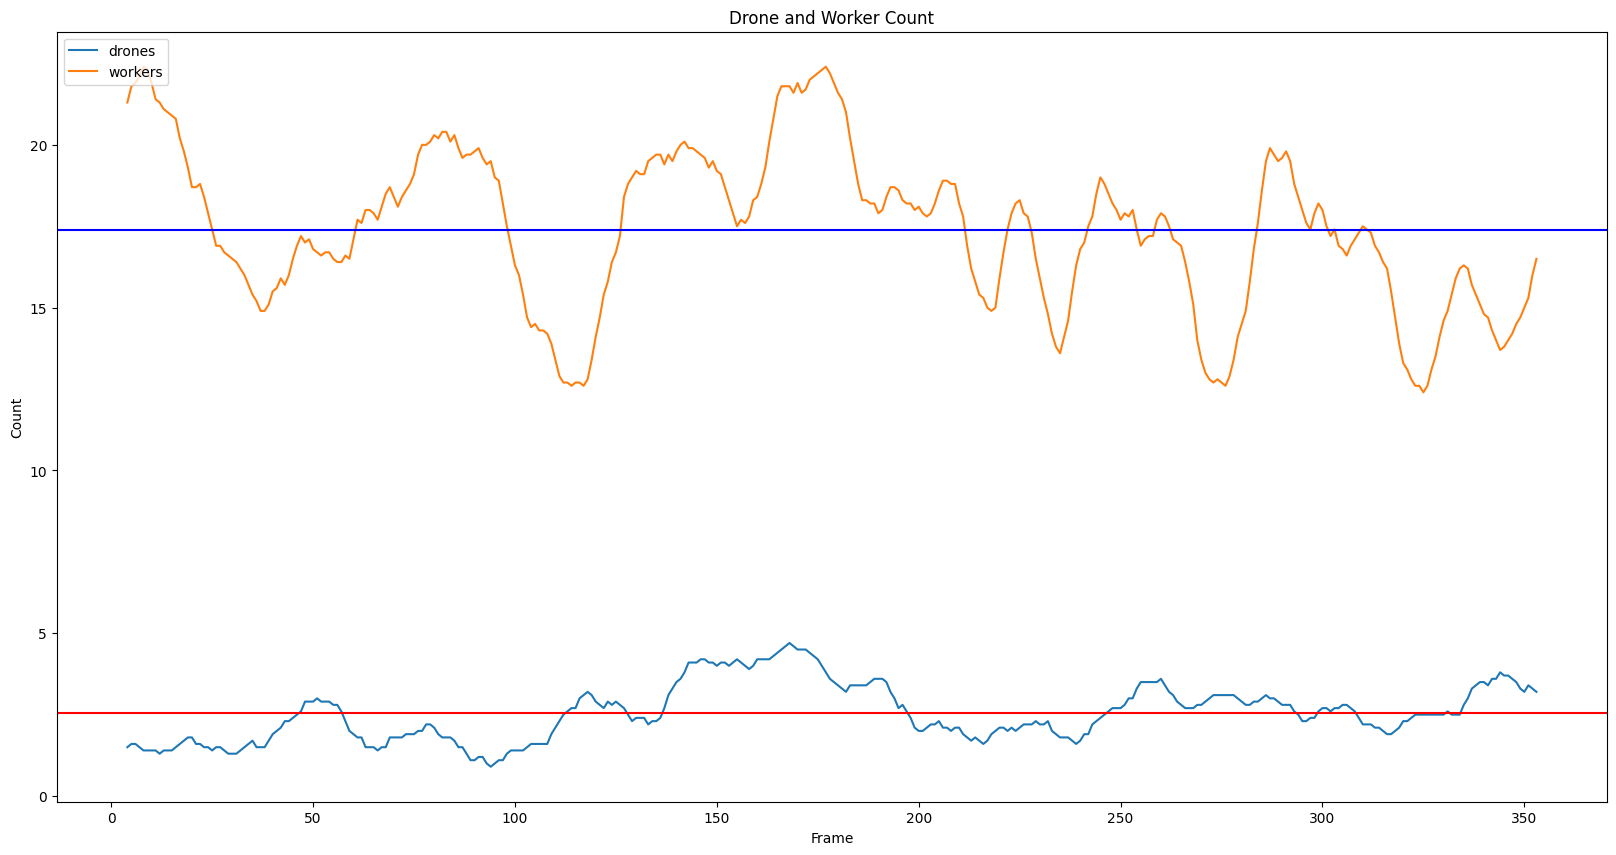

In [11]:
df = pd.read_csv("result.csv")

#add 5ma
df['workers_10ma'] = df['workers'].rolling(window=10).mean()
df['drones_10ma'] = df['drones'].rolling(window=10).mean()
#shift back 10
df['workers_10ma'] = df['workers_10ma'].shift(-5)
df['drones_10ma'] = df['drones_10ma'].shift(-5)

#plot workers and workers 5ma
plt.figure(figsize=(20, 10))
plt.plot(df['workers_10ma'], label='drones')
plt.plot(df['drones_10ma'], label='workers')
plt.legend(loc='upper left')
plt.xlabel('Frame')
plt.ylabel('Count')
plt.title('Drone and Worker Count')
#draw line at average
plt.axhline(y=df['workers_10ma'].mean(), color='r', linestyle='-', label='workers average')
plt.axhline(y=df['drones_10ma'].mean(), color='b', linestyle='-', label='drones average')
plt.show()